In [21]:
import itertools
import os
if os.getcwd().split("/")[-1] == "notebooks":
    os.chdir(os.pardir)
import time

import jax
import jax.numpy as jnp
import jax.nn as nn
from jax import random, vmap, jit, grad
from jax.experimental import optimizers
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
from scipy.special import roots_legendre
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import trange

from pycbem.utils.dataloader import load_sphere_coords

In [22]:
%config InlineBackend.figure_format = 'retina'

In [23]:
data = load_sphere_coords(2312)
data.head()

,x,y,z
0,-0.049703,-0.051179,0.050094
1,0.049703,-0.051179,-0.050094
2,-0.050094,-0.051179,-0.049703
3,0.050094,-0.051179,0.049703
4,-0.049653,0.053037,0.048751


In [24]:
target_area = (2 / 100, 2 / 100)
target_area_origin = (-target_area[0]/2, -target_area[1]/2)
data_target = data[
    (data['y'] < 0) &
    (data['x'] > target_area_origin[0]) &
    (data['x'] < target_area_origin[0] * -1) &
    (data['z'] > target_area_origin[1]) &
    (data['z'] < target_area_origin[1] * -1)]
data_target.reset_index(drop=True, inplace=True)
data_target.head()

,x,y,z
0,-0.009562,-0.088281,0.009294
1,0.009562,-0.088281,-0.009294
2,0.009294,-0.088281,0.009562
3,-0.009294,-0.088281,-0.009562
4,-0.008688,-0.088457,0.008554


In [25]:
X = data_target[['x', 'z']].to_numpy()
y = data_target['y'].to_numpy()

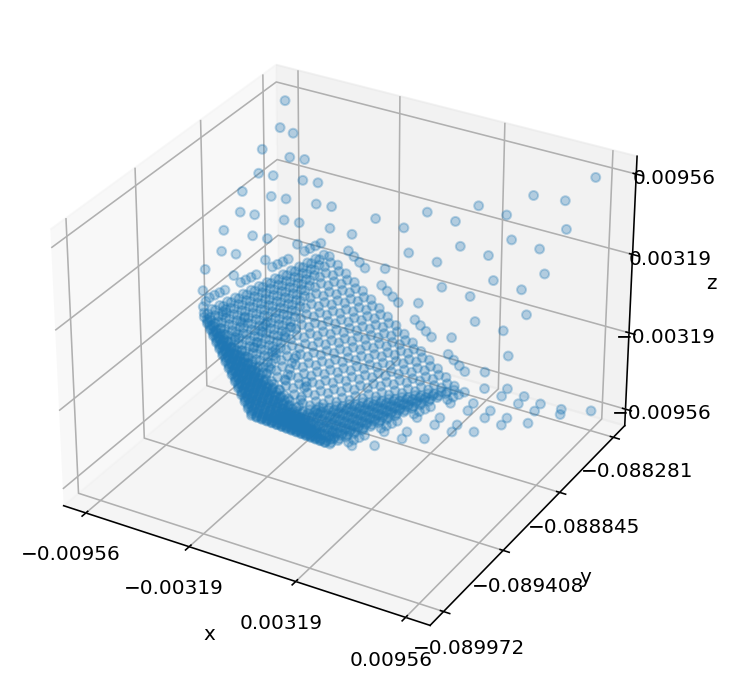

In [26]:
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection ='3d')
ax.scatter(X[:, 0], y, X[:, 1], alpha=0.3)
ax.set(xlabel='x', ylabel='y', zlabel='z',
       xticks=np.mgrid[X[:, 0].min():X[:, 0].max():4j], 
       yticks=np.mgrid[y.min():y.max():4j],
       zticks=np.mgrid[X[:, 1].min():X[:, 1].max():4j]);

In [27]:
def cart2sph(x, y, z):
    r = np.sqrt(x ** 2 + y ** 2 + z ** 2)
    theta = np.arccos(z / r)
    phi = np.arctan2(y, x)
    return r, theta, phi


def sph2cart(r, theta, phi):
    x = r * np.cos(phi) * np.sin(theta)
    y = r * np.sin(phi) * np.sin(theta)
    z = r * np.cos(theta)
    return x, y, z

In [28]:
_, theta, phi = cart2sph(X[:, 0], y, X[:, 1])
theta_a = theta.min()
theta_b = theta.max()
phi_a = phi.min()
phi_b = phi.max()
theta_points, theta_weights = roots_legendre(100)
phi_points, phi_weights = roots_legendre(100)
theta_points = 0.5 * (theta_points + 1.) * (theta_b - theta_a) + theta_a
theta_weights = 0.5 * theta_weights * (theta_b - theta_a)
phi_points = 0.5 * (phi_points + 1.) * (phi_b - phi_a) + phi_a
phi_weights = 0.5 * phi_weights * (phi_b - phi_a)

r = 0.09
phi_grid, theta_grid = np.meshgrid(phi_points, theta_points)
xt, yt, zt = sph2cart(r, theta_grid.ravel(), phi_grid.ravel())

In [29]:
X = np.hstack((xt.reshape(-1, 1), zt.reshape(-1, 1)))
y = np.array(yt).reshape(-1, 1)

In [30]:
X_scaled = X * 100
scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(y)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled)

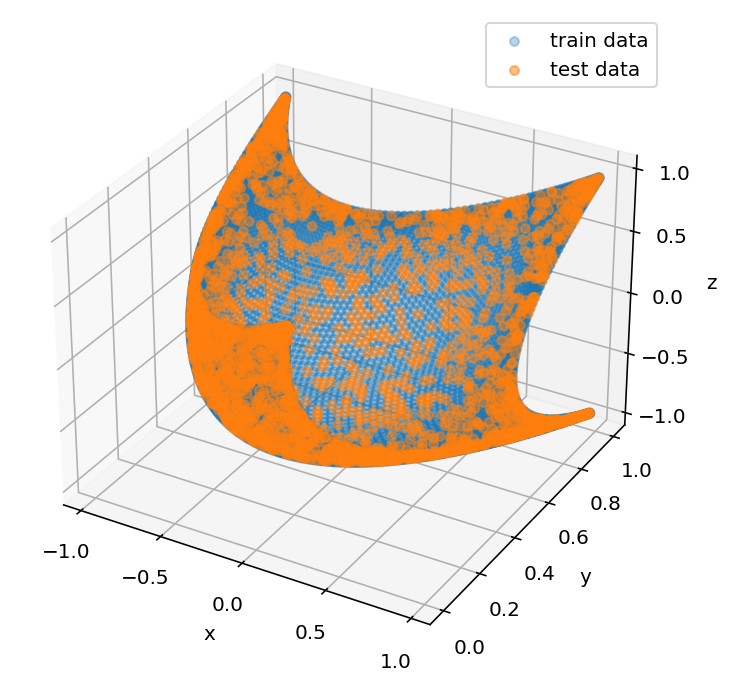

In [32]:
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection ='3d')
ax.scatter(X_train[:, 0], y_train, X_train[:, 1], c='C0', label='train data', alpha=0.3)
ax.scatter(X_test[:, 0], y_test, X_test[:, 1], c='C1', label='test data', alpha=0.5)
ax.set(xlabel='x', ylabel='y', zlabel='z',
       xticks=np.mgrid[-1:1:5j], zticks=np.mgrid[-1:1:5j])
ax.legend();

In [33]:
X_train = jnp.array(X_train)
X_test = jnp.array(X_test)
y_train = jnp.array(y_train)
y_test = jnp.array(y_test)

In [34]:
rng = random.PRNGKey(0)


def init_network_params(sizes, key):
    keys = random.split(key, len(sizes))
    def random_layer_params(m, n, key, scale=1e-2):
        w_key, b_key = random.split(key)
        return (scale * random.normal(w_key, (n, m)),
                scale * random.normal(b_key, (n, )))
    return [random_layer_params(m, n, key)
            for m, n, key in zip(sizes[:-1], sizes[1:], keys)]


def forward(params, X):
    output = X
    for w, b in params[:-1]:
        output = nn.relu(w @ output + b)
    w, b = params[-1]
    output = w @ output + b
    return output


batch_forward = vmap(forward, in_axes=(None, 0))


@jit
def loss_fn(params, batch):
    X, y = batch
    y_pred = batch_forward(params, X)
    return jnp.sum(jnp.square(y_pred - y))


grad_fn = jit(grad(loss_fn))


@jit
def update(step, optim_state, batch):
    params = optim_params(optim_state)
    grads = grad_fn(params, batch)
    optim_state = optim_update(step, grads, optim_state)
    return optim_state


def data_stream(num_train, num_batches):
    rng = npr.RandomState(0)
    while True:
        perm = rng.permutation(num_train)
        for i in range(num_batches):
            batch_idx = perm[i * batch_size:(i + 1) * batch_size]
            yield X_train[batch_idx], y_train[batch_idx]

In [36]:
step_size = 0.001
n_epochs = 500
printout = int(n_epochs / 10.)
batch_size = 128
# momentum_mass = 0.9  # for momentum and adagrad
sizes = [2, 30, 60, 30, 1]

num_train = X_train.shape[0]
num_complete_batches, leftover = divmod(num_train, batch_size)
num_batches = num_complete_batches + bool(leftover)

batches = data_stream(num_train, num_batches)

optim_init, optim_update, optim_params = optimizers.adam(step_size)
init_params = init_network_params(sizes, rng)
optim_state = optim_init(init_params)
itercount = itertools.count()

loss_train, loss_test = [], []
for epoch in trange(n_epochs):
    start_time = time.time()
    for _ in range(num_batches):
        optim_state = update(next(itercount), optim_state, next(batches))
    epoch_time = time.time() - start_time
    
    params = optim_params(optim_state)
    if (epoch == 0) or (epoch % printout == (printout - 1)):
        if epoch == 0:
            print('epoch \t| loss on test set')
            print('----- \t| ----------------')
        loss_train.append(loss_fn(params, (X_train, y_train)))
        l = loss_fn(params, (X_test, y_test))
        loss_test.append(l)
        print(f'{epoch + 1} \t| {l}')

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 	| loss on test set
----- 	| ----------------
1 	| 183.5611572265625
50 	| 0.04931921884417534
100 	| 0.0218820683658123
150 	| 0.023212255910038948
200 	| 0.014910011552274227
250 	| 0.013711225241422653
300 	| 0.019273053854703903
350 	| 0.01236630417406559
400 	| 0.014782704412937164
450 	| 0.03758736327290535
500 	| 0.010571380145847797


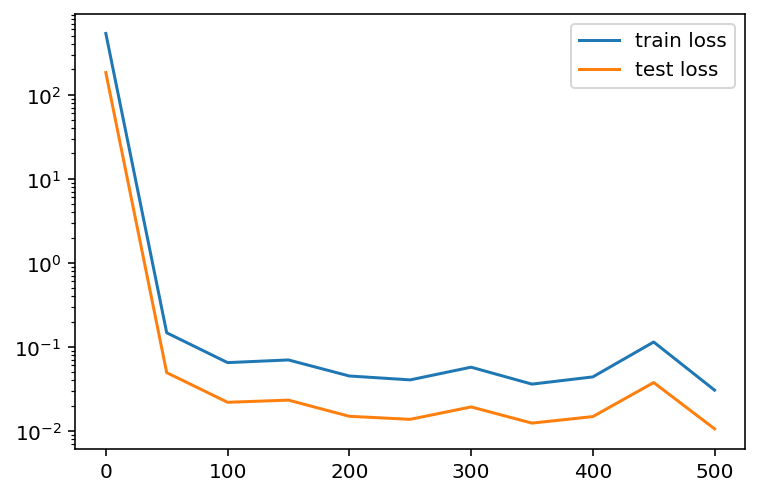

In [37]:
plt.plot(jnp.arange(0, n_epochs+1, printout), loss_train, label='train loss')
plt.plot(jnp.arange(0, n_epochs+1, printout), loss_test, label='test loss')
plt.yscale('log')
plt.legend();

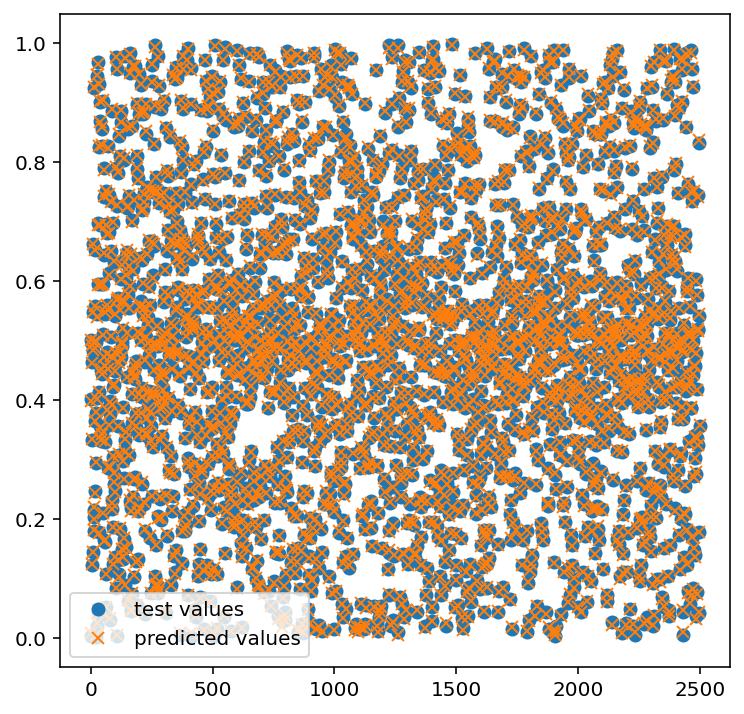

In [38]:
fig = plt.figure(figsize=(6, 6))
plt.plot(y_test.flatten(), 'o', label='test values')
plt.plot(batch_forward(params, X_test).flatten(), 'x', label='predicted values')
plt.legend();

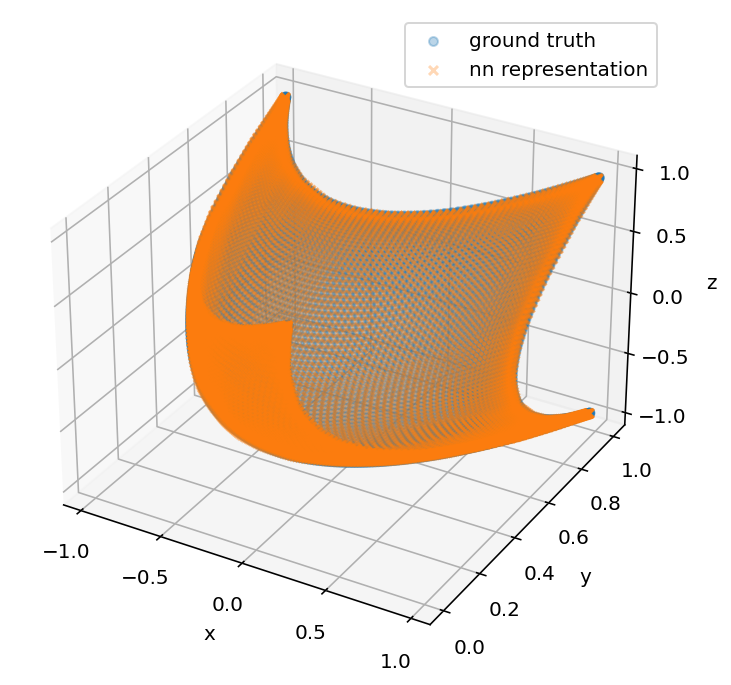

In [39]:
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection ='3d')
ax.scatter(X_scaled[:, 0], y_scaled, X_scaled[:, 1], alpha=0.3, label='ground truth')
ax.scatter(X_scaled[:, 0], batch_forward(params, X_scaled), X_scaled[:, 1], marker='x', alpha=0.3, label='nn representation')
ax.set(xlabel='x', ylabel='y', zlabel='z',
       xticks=jnp.mgrid[-1:1:5j], zticks=jnp.mgrid[-1:1:5j])
ax.legend();

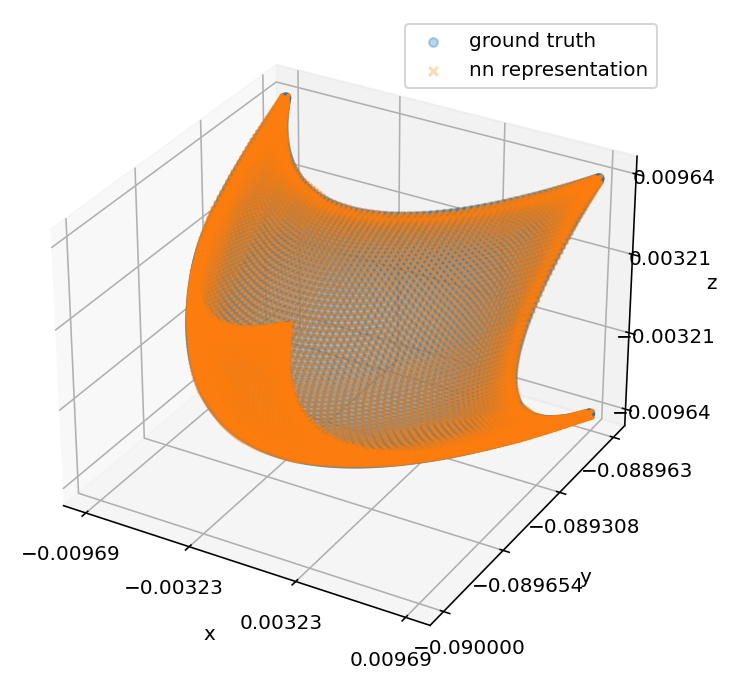

In [40]:
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection ='3d')
ax.scatter(X[:, 0], y, X[:, 1], alpha=0.3, label='ground truth')
ax.scatter(X[:, 0], scaler.inverse_transform(batch_forward(params, X_scaled)), X[:, 1], marker='x', alpha=0.3, label='nn representation')
ax.set(xlabel='x', ylabel='y', zlabel='z',
       xticks=np.mgrid[X[:, 0].min():X[:, 0].max():4j], 
       yticks=np.mgrid[y.min():y.max():4j],
       zticks=np.mgrid[X[:, 1].min():X[:, 1].max():4j]);
ax.legend();